In [1]:
import mglearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [2]:
# 노트북이 코랩에서 실행 중인지 체크합니다.
import os
import sys

import matplotlib.pyplot as plt
import mglearn

if 'google.colab' in sys.modules:
    # 사이킷런 최신 버전을 설치합니다.
    !pip install -q --upgrade scikit-learn
    # mglearn을 다운받고 압축을 풉니다.
    !wget -q -O mglearn.tar.gz https://bit.ly/mglearn-tar-gz
    !tar -xzf mglearn.tar.gz

In [3]:
from preamble import *
import matplotlib

# D2Coding 폰트를 사용합니다.
# matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rc('font', family='D2Coding')
matplotlib.rcParams['axes.unicode_minus'] = False

# 코랩에서 넘파이 경고를 나타내지 않기 위해
import sys
if 'google.colab' in sys.modules:
    import warnings
    warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [4]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 데이터 적재와 분할
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

# 훈련 데이터의 최솟값, 최대값을 계산합니다.
scaler = MinMaxScaler().fit(X_train)

In [5]:
# 훈련 데이터의 스케일을 조정합니다.
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# 스케일 조정된 훈련데이터에 SVM을 학습시킵니다.
svm.fit(X_train_scaled, y_train)
# 테스트 데이터의 스케일을 조정하고 점수를 계산합니다.
X_test_scaled = scaler.transform(X_test)
print("테스트 점수: {:.2f}".format(svm.score(X_test_scaled, y_test)))

테스트 점수: 0.97


### 데이터 전처리와 매개변수 선택

In [6]:
from sklearn.model_selection import GridSearchCV
# 이 코드는 예를 위한 것입니다. 실제로 사용하지 마세요.
param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100],
              'gamma':[0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("최상의 교차 검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 점수: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("최적의 매개변수:", grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 점수: 0.97
최적의 매개변수: {'C': 1, 'gamma': 1}


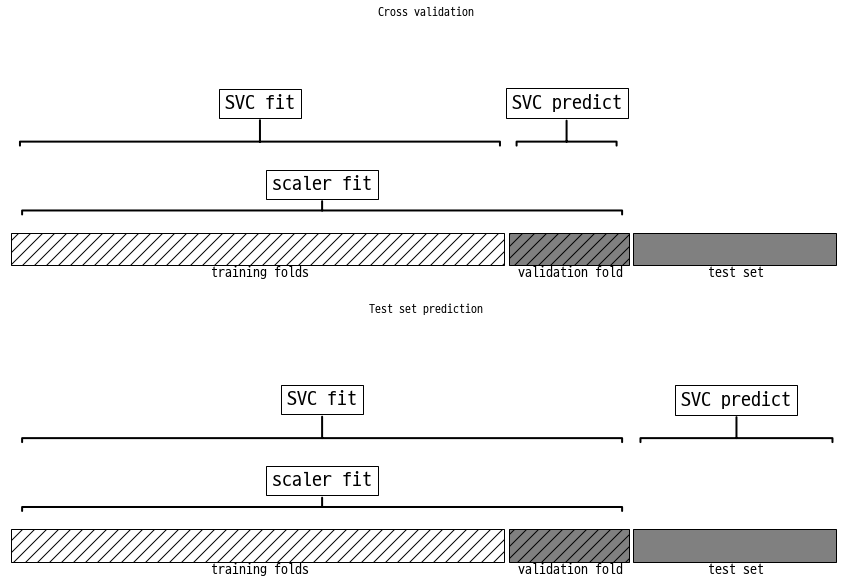

In [7]:
mglearn.plots.plot_improper_processing()

### 파이프라인 구축하기

In [8]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

In [9]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [10]:
print("테스트 점수: {:.2f}".format(pipe.score(X_test, y_test)))

테스트 점수: 0.97


### 그리드 서치에 파이프라인 적용하기

In [11]:
param_grid = {'svm__C':[0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma':[0.001, 0.01, 0.1, 1, 10, 100]}

In [12]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("최상의 교차 검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 점수: {:.2f}".format(grid.score(X_test, y_test)))
print("최적의 매개변수:", grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 점수: 0.97
최적의 매개변수: {'svm__C': 1, 'svm__gamma': 1}


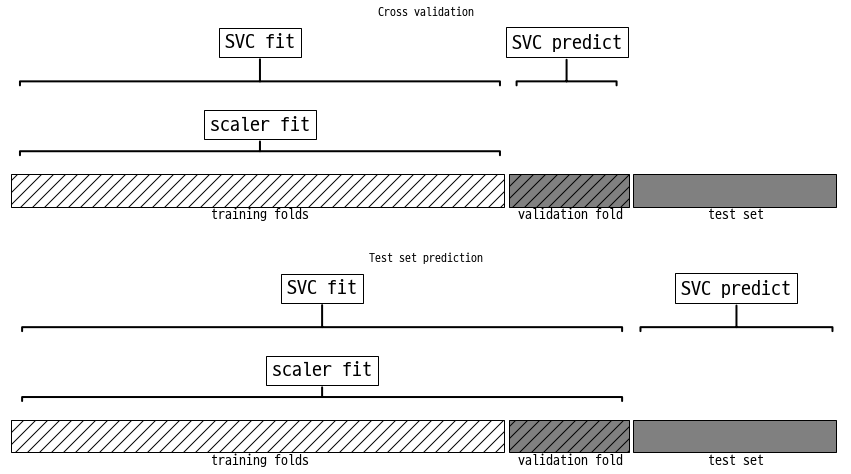

In [13]:
mglearn.plots.plot_proper_processing()

### 정보 누설에 대한 예시

In [14]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

In [15]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print("X_selected.shape:", X_selected.shape)

X_selected.shape: (100, 500)


In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("교차 검증 점수(리지): {:.2f}".format(np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

교차 검증 점수(리지): 0.91


In [18]:
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression, percentile=5)),
                 ("ridge", Ridge())])
print("교차 검증 점수(파이프라인): {:.2f}".format(np.mean(cross_val_score(pipe, X, y, cv=5))))

교차 검증 점수(파이프라인): -0.25


### 파이프라인 인터페이스

In [19]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # 마지막 단계를 빼고 fit과 transform을 반복합니다.
        X_transformed = estimator.fit_transform(X_transformed, y)
    # 마지막 단계 fit을 호출합니다.
    self.steps[-1][1].fit(X_transformed, y)
    return self

In [20]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # 마지막 단계를 빼고 transform을 반복합니다.
        X_transformed = step[1].transform(X_transformed)
    # 마지막 단계 predict을 호출합니다.
    return self.steps[-1][1].predict(X_transformed)

### make_pipeline을 사용한 파이프라인 생성

In [21]:
from sklearn.pipeline import make_pipeline
# 표준적인 방법
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# 간소화된 방법
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [22]:
print("파이프라인 단계:\n", pipe_short.steps)

파이프라인 단계:
 [('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("파이프라인 단계:\n", pipe.steps)

파이프라인 단계:
 [('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


### 단계 속성에 접근하기

In [24]:
# cancer 데이터셋에 앞서 만든 파이프라인을 적용합니다.
pipe.fit(cancer.data)
# 'pca' 단계의 두 개 주성분을 추출합니다.
components = pipe.named_steps["pca"].components_
print("components.shape", components.shape)

components.shape (2, 30)


### 그리드 서치 안의 파이프라인 속성에 접근하기

In [25]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

In [26]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [27]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

In [28]:
print("최상의 모델:\n", grid.best_estimator_)

최상의 모델:
 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1, max_iter=1000))])


In [30]:
print("로지스틱 회귀 단게:\n", grid.best_estimator_.named_steps["logisticregression"])

로지스틱 회귀 단게:
 LogisticRegression(C=1, max_iter=1000)


In [32]:
print("로지스틱 회귀 계수:\n", grid.best_estimator_.named_steps["logisticregression"].coef_)

로지스틱 회귀 계수:
 [[-0.436 -0.343 -0.408 -0.534 -0.15   0.61  -0.726 -0.785  0.039  0.275
  -1.298  0.049 -0.673 -0.934 -0.139  0.45  -0.13  -0.101  0.434  0.716
  -1.091 -1.095 -0.852 -1.064 -0.743  0.073 -0.823 -0.653 -0.644 -0.42 ]]


### 전처리와 모델의 매개변수를 위한 그리드 서치

In [52]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())


In [53]:
param_grid = {'polynomialfeatures__degree':[1, 2, 3], 'ridge__alpha':[0.001, 0.01, 0.1, 1, 10, 100]}

In [54]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

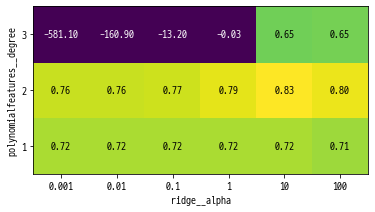

In [56]:
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3, -1),
                      xlabel="ridge__alpha", ylabel="polynomialfeatures__degree",
                      xticklabels=param_grid['ridge__alpha'],
                      yticklabels=param_grid['polynomialfeatures__degree'], vmin=0)

In [57]:
print("최적의 매개변수:", grid.best_params_)

최적의 매개변수: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [58]:
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))

테스트 세트 점수: 0.77


In [59]:
param_grid = {'ridge__alpha':[0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("다항 특성이 없을 때 점수: {:.2f}".format(grid.score(X_test, y_test)))

다항 특성이 없을 때 점수: 0.63


### 모델 선택을 위한 그리드 서치

In [60]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [61]:
from sklearn.ensemble import RandomForestClassifier
param_grid = [
    {'classifier':[SVC()], 'preprocessing':[StandardScaler()],
     'classifier__gamma':[0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier':[RandomForestClassifier(n_estimators=100)],
     'preprocessing':[None], 'classifier__max_features':[1, 2, 3]}]

In [62]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("최적의 매개변수:\n{}\n".format(grid.best_params_))
print("최상의 교차 검증 점수: {:.2f}".format(grid.best_score_))
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))

최적의 매개변수:
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

최상의 교차 검증 점수: 0.99
테스트 세트 점수: 0.98


In [63]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())], memory="cache_folder")